<a href="https://colab.research.google.com/github/EldarEyvazov/PolypSegmentation/blob/main/Unet_dropout_and_data_augmentatio__tf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Unet dropout, data augmentation and dice loss together best model so far, and lastly we are going to add extra layer to if see by increasing model complexity, we can achieve further performance.


In [ ]:
import os, cv2
import numpy as np
import pandas as pd
import random, tqdm
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import albumentations as album
# File processing
from glob import glob
import json
from PIL import Image
from tqdm import tqdm

# Splitting data into train and test sets
from sklearn.model_selection import train_test_split

# Data and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt

from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Concatenate, UpSampling2D, Conv2DTranspose, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

In [ ]:
pip install tf

  Preparing metadata (setup.py) ... done
  Created wheel for tf: filename=tf-1.0.0-py3-none-any.whl size=1260 sha256=9444cc468bf4b5cfbe77080604f8e3fc534abe7c12a6c4c52690763eca49bef3
  Stored in directory: /root/.cache/pip/wheels/3f/c7/25/9e8467cbf247c674b122fbcf00d8fa558c314731cb511c19c5
Successfully built tf


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import cv2
import numpy as np

def read_and_resize_images(img_folder_path, desired_size=(256, 256)):
    images = []
    img_paths = []
    for image_name in sorted(os.listdir(img_folder_path)):
        image_path = os.path.join(img_folder_path, image_name)
        img_paths.append(image_path)

    for img_path in img_paths:
        img = cv2.imread(img_path)
        img = cv2.resize(img, desired_size)
        images.append(img)

    return np.array(images), img_paths


images_folder_path = "/content/drive/MyDrive/Vision Cognitive systems/Kvasir-SEG no augmentation/images"


images, img_p = read_and_resize_images(images_folder_path)



In [ ]:
def read_and_resize_masks(mask_folder_path, desired_size=(256, 256)):
    masks = []
    mask_paths = []
    for mask_name in sorted(os.listdir(mask_folder_path)):
        mask_path = os.path.join(mask_folder_path, mask_name)
        mask_paths.append(mask_path)

    for mask_path in mask_paths:
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, desired_size)
        masks.append(mask)

    return np.array(masks), mask_paths


masks_folder_path = "/content/drive/MyDrive/Vision Cognitive systems/Kvasir-SEG no augmentation/masks"

masks, mask_p = read_and_resize_masks(masks_folder_path)

In [ ]:
def split_data(images, masks, split=0.2):
    total_size = len(images)
    test_size  = int(split * total_size)
    valid_size = int(split * total_size)

    X_train, X_valid = train_test_split(images, test_size=valid_size, random_state=42)
    y_train, y_valid = train_test_split(masks, test_size=valid_size, random_state=42)

    X_train, X_test = train_test_split(X_train, test_size=test_size, random_state=42)
    y_train, y_test = train_test_split(y_train, test_size=test_size, random_state=42)
    return (X_train, y_train), (X_valid, y_valid), (X_test, y_test)

In [ ]:
(X_train, y_train), (X_valid, y_valid), (X_test, y_test) = split_data(images, masks)

print(f"train set size: {len(X_train)}\nvalid set size: {len(X_valid)}\ntest set size:  {len(X_test)}")

train set size: 600
valid set size: 200
test set size:  200


In [ ]:
# Find the maximum and minimum pixel values in each channel of the images array
max_pixel_values = np.amax(images, axis=(0, 1, 2))  # Max value for each channel
min_pixel_values = np.amin(images, axis=(0, 1, 2))  # Min value for each channel

print("Maximum pixel values (R, G, B):", max_pixel_values)
print("Minimum pixel values (R, G, B):", min_pixel_values)


Maximum pixel values (R, G, B): [255 255 255]
Minimum pixel values (R, G, B): [0 0 0]


In [ ]:
# Rescale the pixel values of images to the range [0, 1] for each channel
images = images / 255.0

# Find the maximum and minimum pixel values in each channel of the rescaled images array
max_rescaled_values = np.amax(images, axis=(0, 1, 2))  # Max value for each channel
min_rescaled_values = np.amin(images, axis=(0, 1, 2))  # Min value for each channel

print("Maximum rescaled pixel values (R, G, B):", max_rescaled_values)
print("Minimum rescaled pixel values (R, G, B):", min_rescaled_values)

Maximum rescaled pixel values (R, G, B): [1. 1. 1.]
Minimum rescaled pixel values (R, G, B): [0. 0. 0.]


In [ ]:
# Find the maximum and minimum pixel values in the masks array
max_pixel_value = np.amax(masks)
min_pixel_value = np.amin(masks)

print("Maximum pixel value for the masks:", max_pixel_value)
print("Minimum pixel value for the masks:", min_pixel_value)



Maximum pixel value for the masks: 255
Minimum pixel value for the masks: 0


In [ ]:

# Rescale the pixel values of masks to the range [0, 1]
masks = masks / max_pixel_value

# Find the maximum and minimum pixel values in the rescaled masks array
max_rescaled_value = np.amax(masks)
min_rescaled_value = np.amin(masks)

print("Maximum rescaled pixel value for the masks:", max_rescaled_value)
print("Minimum rescaled pixel value for the masks:", min_rescaled_value)

Maximum rescaled pixel value for the masks: 1.0
Minimum rescaled pixel value for the masks: 0.0


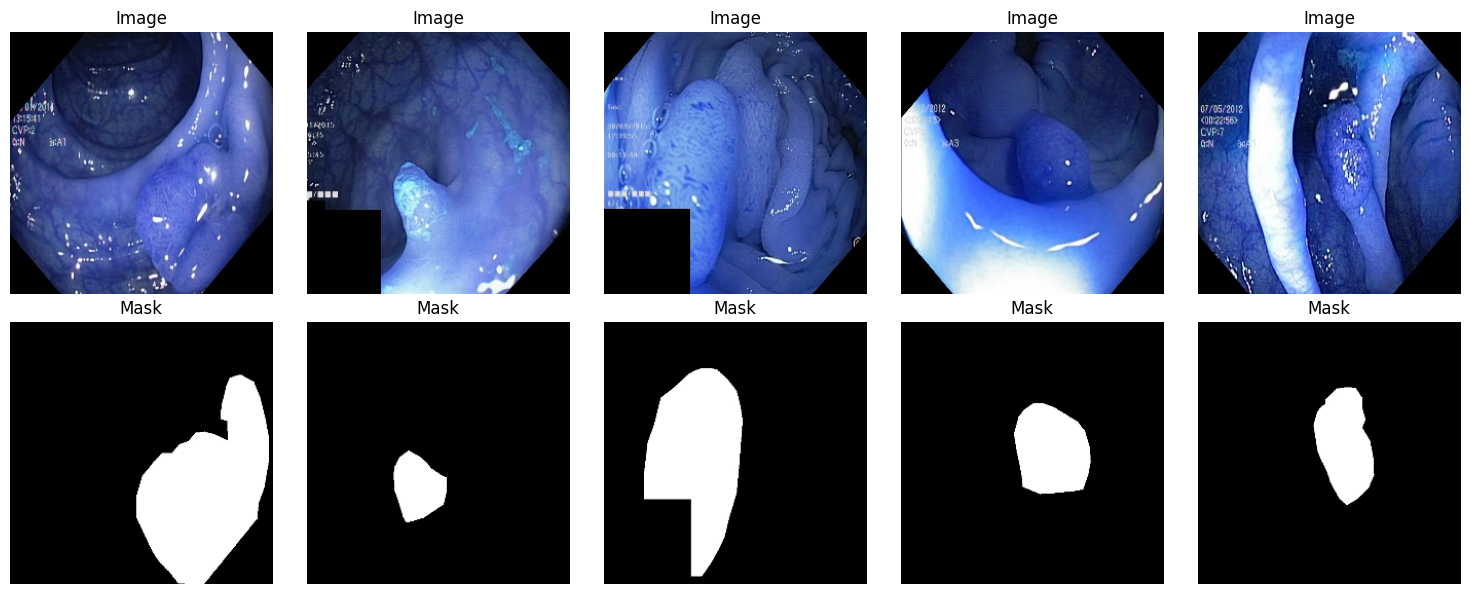

In [ ]:
import matplotlib.pyplot as plt
import random


# Set up the figure for plotting
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

# Randomly select 5 indices
random_indices = random.sample(range(len(images)), 5)

# Plot the images and masks
for i, idx in enumerate(random_indices):
    # Plot the image
    axes[0, i].imshow(images[idx])
    axes[0, i].set_title("Image")
    axes[0, i].axis("off")

    # Plot the mask
    axes[1, i].imshow(masks[idx], cmap='gray')
    axes[1, i].set_title("Mask")
    axes[1, i].axis("off")

plt.tight_layout()
plt.show()


In [ ]:
from tqdm import tqdm
import albumentations as A
import numpy as np

# Define Albumentations transformations
transformations = A.Compose(
    [
        A.OneOrOther(
            A.Compose([
                A.RandomRotate90(),
                A.HorizontalFlip(p=0.5)
            ]),
            A.Rotate(p=0.5)
        ),
        A.HorizontalFlip(p=1),
        A.RandomBrightnessContrast(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=30, p=0.5),
        A.CLAHE(clip_limit=4.0, tile_grid_size=(8, 8), p=0.2)
    ]
)

# Create lists for storing the augmented images and masks
augmented_images = []
augmented_masks = []

# Number of times to apply augmentation for each image
num_augmentations = 4

# Apply transformations
for image, mask in tqdm(zip(X_train, y_train), total=X_train.shape[0]):
    for _ in range(num_augmentations):
        # Apply Albumentations transformations
        augmented = transformations(image=image, mask=mask)
        augmented_images.append(augmented['image'])
        augmented_masks.append(augmented['mask'])

# Convert the lists to numpy arrays
X_train = np.array(augmented_images)
y_train = np.array(augmented_masks)


100%|██████████| 600/600 [00:04<00:00, 131.17it/s]


In [ ]:
X_train.shape

(2400, 256, 256, 3)

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, Concatenate, BatchNormalization
from tensorflow.keras.models import Model
#adding dropout to encoder and decoder part
def Unet(input_shape):

    # Encoder
    inputs = Input(input_shape)

    layer1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    layer1 = BatchNormalization()(layer1)
    layer1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(layer1)
    layer1 = BatchNormalization()(layer1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(layer1)
    pool1 = Dropout(0.25)(pool1)  # Adding dropout after pooling

    layer2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool1)
    layer2 = BatchNormalization()(layer2)
    layer2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(layer2)
    layer2 = BatchNormalization()(layer2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(layer2)
    pool2 = Dropout(0.25)(pool2)  # Adding dropout after pooling

    layer3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool2)
    layer3 = BatchNormalization()(layer3)
    layer3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(layer3)
    layer3 = BatchNormalization()(layer3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(layer3)
    pool3 = Dropout(0.25)(pool3)  # Adding dropout after pooling

    layer4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool3)
    layer4 = BatchNormalization()(layer4)
    layer4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(layer4)
    layer4 = BatchNormalization()(layer4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(layer4)
    pool4 = Dropout(0.25)(pool4)  # Adding dropout after pooling

    # Bottleneck
    layer5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool4)
    layer5 = BatchNormalization()(layer5)
    layer5 = Dropout(0.5)(layer5)  # Already we haved used it
    layer5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(layer5)
    layer5 = BatchNormalization()(layer5)

    # Decoder
    upsam1 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(layer5)
    upsam1 = Concatenate()([upsam1, layer4])
    layer6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(upsam1)
    layer6 = BatchNormalization()(layer6)
    layer6 = Dropout(0.25)(layer6)  # Adding dropout

    upsam2 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(layer6)
    upsam2 = Concatenate()([upsam2, layer3])
    layer7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(upsam2)
    layer7 = BatchNormalization()(layer7)
    layer7 = Dropout(0.25)(layer7)  # Adding dropout

    upsam3 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(layer7)
    upsam3 = Concatenate()([upsam3, layer2])
    layer8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(upsam3)
    layer8 = BatchNormalization()(layer8)
    layer8 = Dropout(0.25)(layer8)  # Adding dropout

    upsam4 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(layer8)
    upsam4 = Concatenate()([upsam4, layer1])
    layer9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(upsam4)
    layer9 = BatchNormalization()(layer9)
    layer9 = Dropout(0.25)(layer9)  # Adding dropout

    # Output
    layer10 = Conv2D(1, (1, 1), activation='sigmoid')(layer9)

    model = Model(inputs=inputs, outputs=layer10)

    return model


In [ ]:
model = Unet((256, 256, 3))
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_30 (Conv2D)          (None, 256, 256, 16)         448       ['input_3[0][0]']             
                                                                                                  
 batch_normalization_28 (Ba  (None, 256, 256, 16)         64        ['conv2d_30[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 conv2d_31 (Conv2D)          (None, 256, 256, 16)         2320      ['batch_normalization_28

In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Define custom metrics
def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection ) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def iou_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    total = K.sum(y_true_f) + K.sum(y_pred_f)
    union = total - intersection
    return (intersection ) / (union + smooth)

In [ ]:
from tensorflow.keras import backend as K

def dice_loss(y_true, y_pred, smooth=1e-6):
    y_true = K.cast(y_true, 'float32')  # Ensure y_true is float32
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


In [ ]:

# Ensure masks are binary
y_train = (y_train > 0).astype('float32')
y_valid = (y_valid > 0).astype('float32')
y_test = (y_test > 0).astype('float32')


In [ ]:
import tensorflow as tf
import csv
from tensorflow.keras.callbacks import Callback, ModelCheckpoint


# Custom callback to save metrics to CSV
class CSVLogger(Callback):
    def __init__(self, filename, separator=',', append=False):
        super(CSVLogger, self).__init__()
        self.sep = separator
        self.filename = filename
        self.append = append
        self.csv_file = None
        self.writer = None
        self.keys = None
        self.append_header = True

    def on_train_begin(self, logs=None):
        if self.append:
            if tf.io.gfile.exists(self.filename):
                with open(self.filename, 'r') as f:
                    self.append_header = not bool(len(f.readline()))
            mode = 'a'
        else:
            mode = 'w'

        self.csv_file = open(self.filename, mode, newline='')
        self.writer = csv.DictWriter(self.csv_file, fieldnames=None, delimiter=self.sep)
        self.keys = None

    def on_epoch_end(self, epoch, logs=None):
        if not self.keys:
            self.keys = sorted(logs.keys())
            self.writer.fieldnames = ['epoch'] + self.keys
            if self.append_header:
                self.writer.writeheader()

        row_dict = {'epoch': epoch}
        row_dict.update((key, logs[key]) for key in self.keys)
        self.writer.writerow(row_dict)
        self.csv_file.flush()

    def on_train_end(self, logs=None):
        if self.csv_file:
            self.csv_file.close()
            self.csv_file = None
            self.writer = None
            self.keys = None




In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

def train_model(model, X_train, y_train, X_valid, y_valid, batch_size, epochs, save_path, csv_log_path):
    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                  loss=dice_loss,
                  metrics=['accuracy', iou_coef, dice_coef])

    # Define callbacks
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-8, verbose=1)
    early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
    csv_logger = CSVLogger(filename=csv_log_path)

    # Train the model
    history = model.fit(X_train, y_train,
                        validation_data=(X_valid, y_valid),
                        epochs=epochs,
                        batch_size=batch_size,
                        callbacks=[reduce_lr, early_stopping, csv_logger])

    # Save the model
    model.save(save_path)

    return history
# Paths for saving metrics and the model
csv_log_path = '/content/drive/MyDrive/Vision Cognitive systems/Kvasir-SEG no augmentation/results/unet_aug/training_metrics_unet_aug.csv'
save_path = '/content/drive/MyDrive/Vision Cognitive systems/Kvasir-SEG no augmentation/results/unet_aug'

# Train the model
history = train_model(model, X_train, y_train, X_valid, y_valid, batch_size=12, epochs=60, save_path=save_path, csv_log_path=csv_log_path)


Epoch 1/60
200/200 [==============================] - 37s 143ms/step - loss: 0.5628 - accuracy: 0.7046 - iou_coef: 0.2833 - dice_coef: 0.4372 - val_loss: 0.5259 - val_accuracy: 0.7102 - val_iou_coef: 0.3144 - val_dice_coef: 0.4748 - lr: 0.0010
Epoch 2/60
200/200 [==============================] - 28s 140ms/step - loss: 0.4967 - accuracy: 0.7979 - iou_coef: 0.3391 - dice_coef: 0.5033 - val_loss: 0.4915 - val_accuracy: 0.7465 - val_iou_coef: 0.3448 - val_dice_coef: 0.5087 - lr: 0.0010
Epoch 3/60
200/200 [==============================] - 28s 138ms/step - loss: 0.4645 - accuracy: 0.8212 - iou_coef: 0.3689 - dice_coef: 0.5355 - val_loss: 0.4404 - val_accuracy: 0.8497 - val_iou_coef: 0.3928 - val_dice_coef: 0.5588 - lr: 0.0010
Epoch 4/60
200/200 [==============================] - 28s 138ms/step - loss: 0.4425 - accuracy: 0.8367 - iou_coef: 0.3893 - dice_coef: 0.5575 - val_loss: 0.4074 - val_accuracy: 0.8562 - val_iou_coef: 0.4281 - val_dice_coef: 0.5927 - lr: 0.0010
Epoch 5/60
200/200 [====

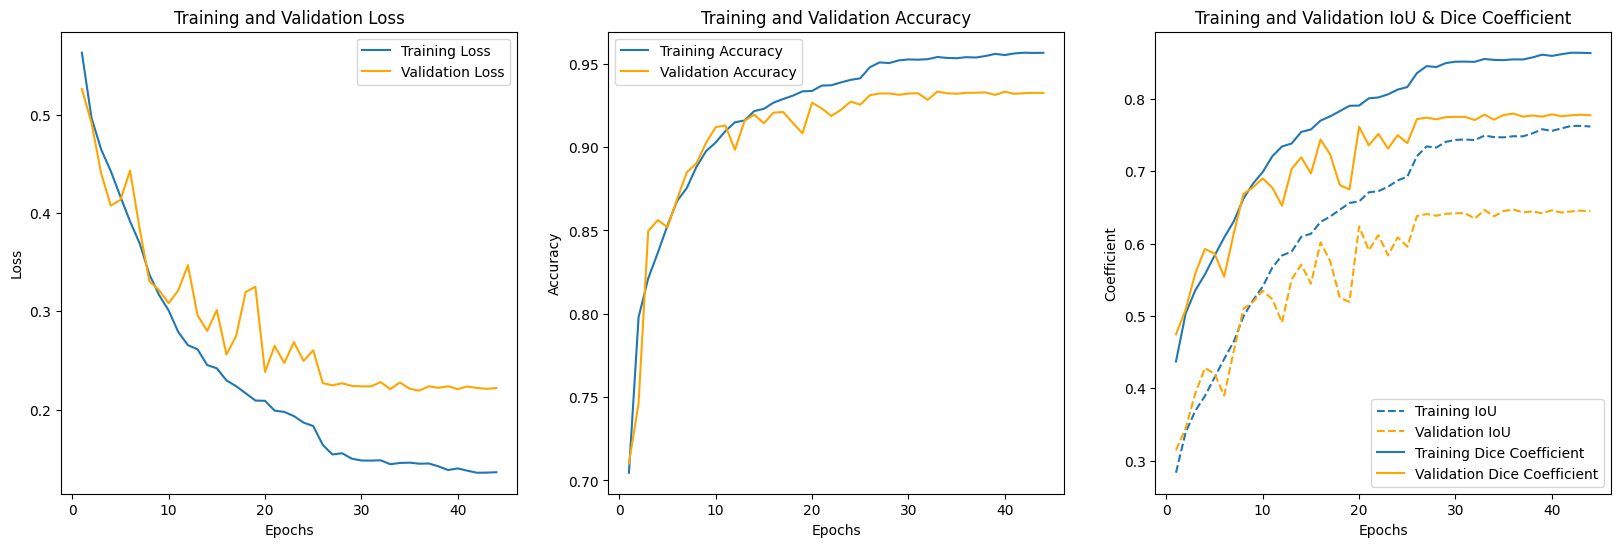

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

csv_log_path = '/content/drive/MyDrive/Vision Cognitive systems/Kvasir-SEG no augmentation/results/unet_aug/training_metrics_unet_aug.csv'
# Load the CSV file into a DataFrame
df = pd.read_csv(csv_log_path)

# Extract metrics from the DataFrame
epochs = df['epoch'] + 1
loss = df['loss']
val_loss = df['val_loss']
accuracy = df['accuracy']
val_accuracy = df['val_accuracy']
iou = df['iou_coef']
val_iou = df['val_iou_coef']
dice = df['dice_coef']
val_dice = df['val_dice_coef']

# Plot training and validation metrics
plt.figure(figsize=(20, 6))

# Subplot 1: Loss
plt.subplot(1, 3, 1)
plt.plot(epochs, loss, label='Training Loss', color='#1f77b4')
plt.plot(epochs, val_loss, label='Validation Loss', color='orange')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(False)

# Subplot 2: Accuracy
plt.subplot(1, 3, 2)
plt.plot(epochs, accuracy, label='Training Accuracy', color='#1f77b4')
plt.plot(epochs, val_accuracy, label='Validation Accuracy', color='orange')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(False)

# Subplot 3: IoU and Dice Coefficient
plt.subplot(1, 3, 3)
plt.plot(epochs, iou, label='Training IoU', color='#1f77b4', linestyle='--')
plt.plot(epochs, val_iou, label='Validation IoU', color='orange', linestyle='--')
plt.plot(epochs, dice, label='Training Dice Coefficient', color='#1f77b4')
plt.plot(epochs, val_dice, label='Validation Dice Coefficient', color='orange')
plt.title('Training and Validation IoU & Dice Coefficient')
plt.xlabel('Epochs')
plt.ylabel('Coefficient')
plt.legend()
plt.grid(False)

plt.show()


25/25 [==============================] - 1s 20ms/step - loss: 0.1875 - accuracy: 0.9450 - iou_coef: 0.6880 - dice_coef: 0.8125
Test Loss: 0.18753549456596375
Test Accuracy: 0.9449999928474426
IoU: 0.6880204677581787
Dice: 0.8124645948410034
25/25 [==============================] - 1s 14ms/step


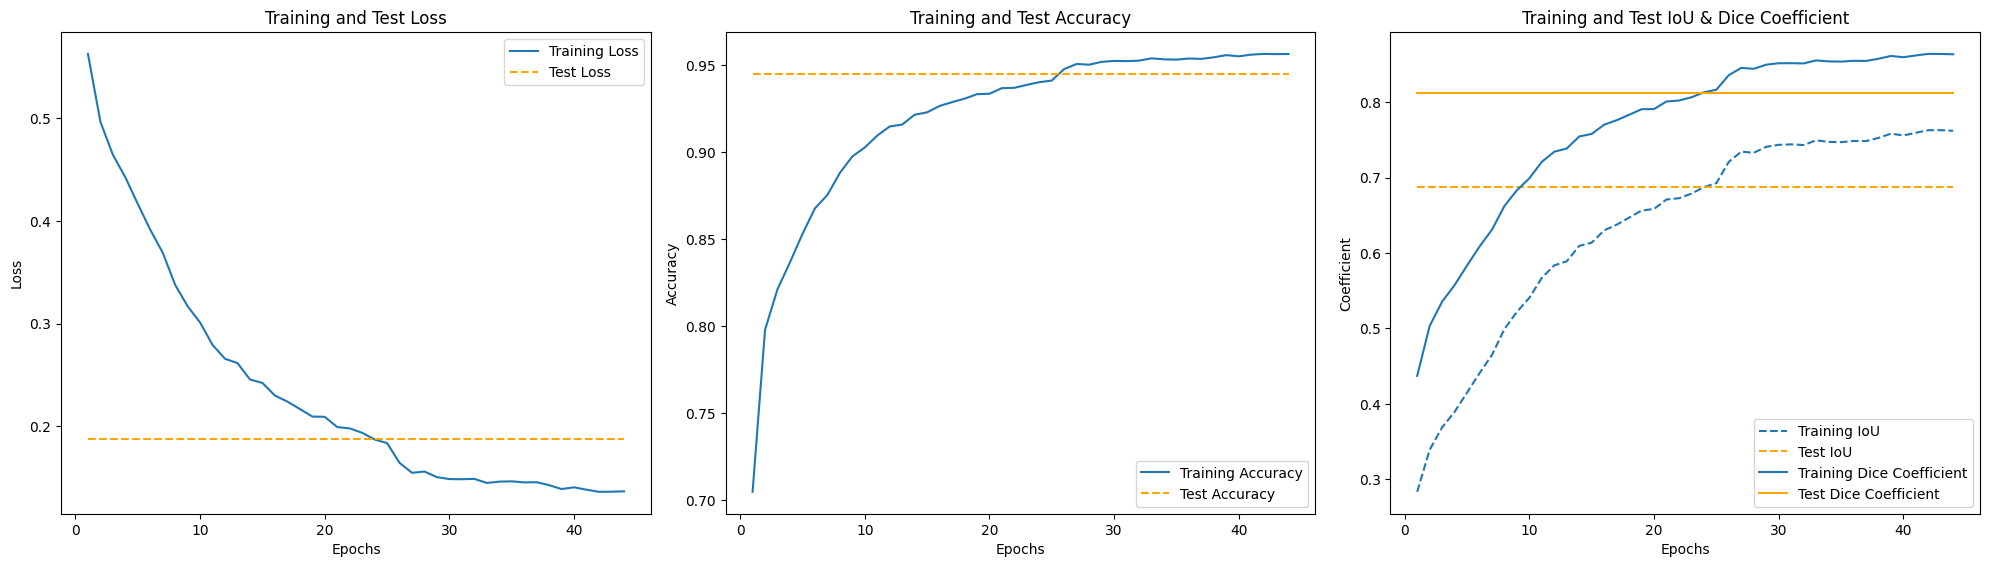

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Paths for the CSV log file
csv_log_path = '/content/drive/MyDrive/Vision Cognitive systems/Kvasir-SEG no augmentation/results/unet_aug/training_metrics_unet_aug.csv'

# Load the CSV file into a DataFrame
df = pd.read_csv(csv_log_path)

# Extract metrics from the DataFrame
epochs = df['epoch'] + 1
train_loss = df['loss']
train_accuracy = df['accuracy']
train_iou = df['iou_coef']
train_dice = df['dice_coef']

# Evaluate the model on the test set
loss, accuracy, iou, dice = model.evaluate(X_test, y_test, batch_size=12)
print(f'Test Loss: {loss}\nTest Accuracy: {accuracy}\nIoU: {iou}\nDice: {dice}')

# Generate predictions on the test set
predictions = model.predict(X_test, batch_size=8)

# Create lists for test metrics to match the number of epochs
test_loss_list = [loss] * len(epochs)
test_accuracy_list = [accuracy] * len(epochs)
test_iou_list = [iou] * len(epochs)
test_dice_list = [dice] * len(epochs)

# Plot training and test metrics
plt.figure(figsize=(20, 6))

# Subplot 1: Loss
plt.subplot(1, 3, 1)
plt.plot(epochs, train_loss, label='Training Loss', color="#1f77b4")
plt.plot(epochs, test_loss_list, label='Test Loss', color='orange', linestyle='--')
plt.title('Training and Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(False)

# Subplot 2: Accuracy
plt.subplot(1, 3, 2)
plt.plot(epochs, train_accuracy, label='Training Accuracy', color='#1f77b4')
plt.plot(epochs, test_accuracy_list, label='Test Accuracy', color='orange', linestyle='--')
plt.title('Training and Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(False)

# Subplot 3: IoU and Dice Coefficient
plt.subplot(1, 3, 3)
plt.plot(epochs, train_iou, label='Training IoU', color='#1f77b4', linestyle='--')
plt.plot(epochs, test_iou_list, label='Test IoU', color='orange', linestyle='--')
plt.plot(epochs, train_dice, label='Training Dice Coefficient', color='#1f77b4')
plt.plot(epochs, test_dice_list, label='Test Dice Coefficient', color='orange')
plt.title('Training and Test IoU & Dice Coefficient')
plt.xlabel('Epochs')
plt.ylabel('Coefficient')
plt.legend()
plt.grid(False)

plt.tight_layout()
plt.subplots_adjust(top=0.9)  # Adjust the top margin
plt.show()


In [ ]:
# Plotting the images with their original and predicted masks
import random

num_images = 10
plt.figure(figsize=(20, 8))
for i in range(num_images):
    idx = random.randint(0, len(X_test) - 1)

    plt.subplot(3, num_images, i + 1)
    img_rgb = cv2.cvtColor(X_test[idx], cv2.COLOR_BGR2RGB) if X_test[idx].shape[-1] == 3 else X_test[idx]
    plt.imshow(img_rgb)
    plt.title('Test Image')
    plt.axis('off')

    plt.subplot(3, num_images, num_images + i + 1)
    plt.imshow(y_test[idx], cmap='gray')
    plt.title('Test Mask')
    plt.axis('off')

    plt.subplot(3, num_images, 2*num_images + i + 1)
    plt.imshow(predictions[idx], cmap='viridis')
    plt.title('Predicted Mask')
    plt.axis('off')

plt.show()

25/25 [==============================] - 0s 18ms/step


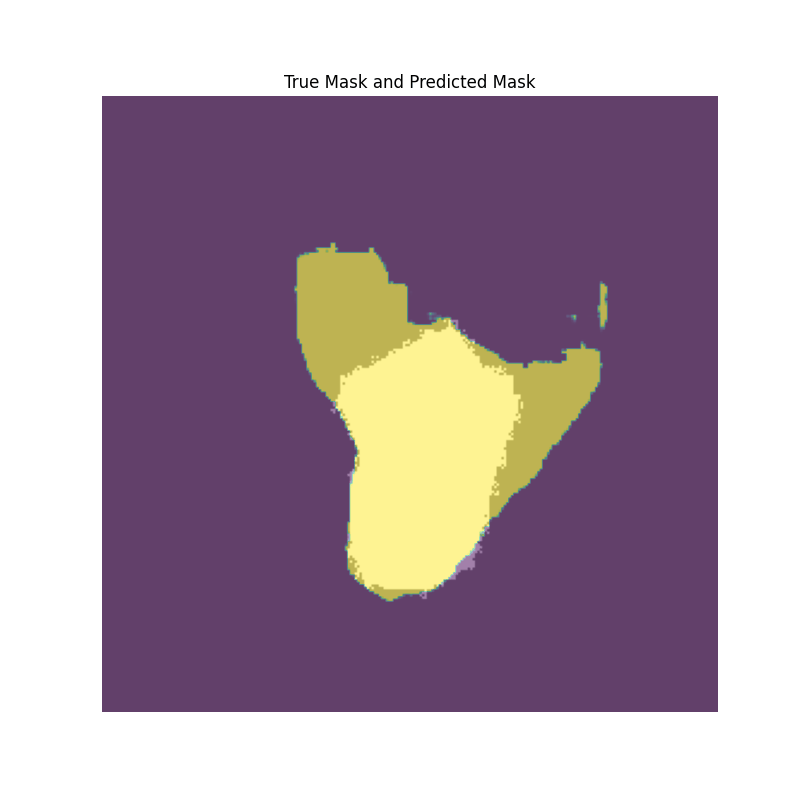

In [ ]:
import imageio
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image

# Generate predictions on the test set
predictions = model.predict(X_test, batch_size=8)

# Create and save a GIF of true masks and predicted masks overlaid
gif_images = []

for i in range(len(X_test)):
    fig, ax = plt.subplots(figsize=(8, 8))

    # True Mask (overlay)
    ax.imshow(y_test[i], cmap='gray', alpha=0.5)
    ax.set_title('True Mask and Predicted Mask')
    ax.axis('off')

    # Predicted Mask (overlay)
    ax.imshow(predictions[i], cmap='viridis', alpha=0.5)

    # Convert plot to image and append to gif_images list
    fig.canvas.draw()
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    gif_images.append(image)

    plt.close(fig)

# Save the GIF
gif_path = "/content/drive/MyDrive/Vision Cognitive systems/Kvasir-SEG no augmentation/predictions_overlay.gif"
imageio.mimsave(gif_path, gif_images, fps=1)

# Display the GIF
Image(filename=gif_path)
